# Structure-Optimized Potential Refinement: An Example on Liquid Neon

Brennon Shanks 

University of Utah Department of Chemical Engineering

## Background

Structure is a profound emergent property of matter. In fact, the manner in which molecular systems exchange energy, organize, and self-assemble largely determines their thermodynamic and electronic behavior. It is therefore important to have accurate experimental and theoretical techniques to characterize and understand microstructure in the dense phases if we hope to design and implement new liquid state technologies for engineering applications. 

We can measure the structure of a liquid experimentally with elastic neutron diffraction, in which interactions between neutrons and the atomic nuclei in the liquid sample are analyzed via scattering theory to estimate the time-averaged atomic positions. The resultant diffraction pattern, known as the total structure factor, gives a momentum space description of the waves diffracted from the sample. In monoatomic and homogenous systems, the total structure factor is related to the real space pair correlation function via Fourier transform [1] such that,

$$
 S(Q) = 1 + \frac{4 \pi}{Q \rho} \frac{\langle b \rangle^2 }{\langle |f(Q)|^2 \rangle} \int_0^\infty r [g(r) - 1] \sin (Qr) dr
$$

where $Q$ is the momentum transfer, $b$ is the scattering length density, $f(Q)$ is the form factor, and $\rho$ is the atomic number density. 

Now, suppose we want to construct a molecular model based on this experimental structure measurement. How could we do this? One option would be to sample a large number of models and look for the one that gives the closest prediction to experiment. However, checking these models may require impractical computational time and resources; and furthermore, there is no guarantee that an accurate enough model even exists! Rather than apply this shotgun approach, we want to appeal to our understanding of statistical mechanics and the relationship between structure and interatomic interactions to reduce the amount of models we need to test and also guarantee that we find model that matches the experimental structure with high-accuracy, every time.

So what does statistical mechanics tell us about the relationship between the interatomic potential and structure? One such relation is known as the structure-potential uniqueness theorem, which relates the difference between the pair potentials ($\Delta v_2(r_o)$) and radial distribution functions ($\Delta g(r_o)$) between two pairwise additive ensembles at all radial distances $r_o$ such that,

$$
    \Delta v_2(r_o)\Delta g(r_o) \leq 0
$$

which is true only when $\Delta v_2(r_o)$ and $\Delta g(r_o)$ have opposite sign. This equation prescribes what direction that an initial guess for the model potential should be corrected given the difference between the model and target experimental radial distribution function at any point $r_o \in r$; namely, by decreasing the potential if $\Delta g(r_o)$ is negative and increasing the potential if $\Delta g(r_o)$ is positive. We therefore need to guess an initial pair potential, run a simulation to calculate the radial distribution function, and then take the difference between this simulated and experimental radial distribution function at all points in $r$. Based on this difference, we know that we need to change our initial guess for the pair potential, up or down, based on the sign of the radial distribution function difference. In SOPR, iterative refinement of a reference (model) potential, $v_2^{0}(r_i)$, is performed with a continuous sum of the $\Delta g^{(n)}(r_i)$ such that,

$$
    v_{2}^{(n)}(r_i) = v_2^{0}(r_i) +  \lambda \beta^{-1} \sum_n \Delta g^{(n)} (r_i) 
$$

where $i$ is the radial index of the tabulated potential, $v_{2}^{(n)}(r_i)$ is the tabulated structure-optimized pair potential at iteration $n$, $\beta$ is the inverse thermal energy $\bigg(\frac{1}{k_B T}\bigg)$, and $0 < \lambda \leq 1$ is an empirical scaling constant to dampen the potential correction and improve numerical stability.

This notebook provides an updated code for structure-optimized potential refinement (SOPR), published in our recent paper on noble gas liquids [2]. We demonstrated that this approach generates tabulated potentials that give excellent agreement between simulated and experimental radial distribution functions and vapor-liquid equilibria from the triple to the critical point.

## Install Software and Import Packages

Below are the packages that need to be installed for the notebook to run. You will need to install and compile four software packages before running the code below.

HOOMD_Blue ver 3.0.0: https://hoomd-blue.readthedocs.io/en/latest/installation.html

Mbuild ver 0.14.2: https://mbuild.mosdef.org/en/stable/ 

Foyer ver 0.11.0: https://foyer.mosdef.org/en/stable/

Freud ver 2.8.0: https://freud.readthedocs.io/en/latest/

In [9]:
#Import computational packages
import numpy as np                         
import matplotlib.pyplot as plt                      
from scipy.optimize import fsolve      
from scipy.optimize import curve_fit   
from scipy import interpolate         

import pandas as pd                   
import csv                              
import gsd                           
import time
import math
import itertools

import hoomd
import gsd.hoomd
import freud

from numpy import array, empty, linspace, arange, diag, maximum, sqrt, exp
from numpy.linalg import eigh

#matplotlib format
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

def radius(x, y):
    Nx, Ny = x.shape[0], y.shape[0]
    r = empty((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            r[i, j] = (x[i] - y[j])
    return r

# radius:
#     Distance function for Gaussian process regression
# arguments:
#     x = x-coordinates
#     y = y-coordinates 
# returns:
#     r = Euclidean distance between input coordinates

def SquareExp(w, l, R):
    K0 = exp(-(R / l)**2)
    return w**2 * K0

# SquareExp:
#     Squared exponential kernel for Gaussian process regression
# arguments:
#     w = weight parameter, default is 0.01
#     l = length-scale fluctuation parameter that specifies oscillation length-scale in regressed points
#     R = Euclidean distance between points in parameter space (given by radius function)   
# returns:
#     w^2*exp(-(R / l)**2) = infinitely differentiable and continuous kernel

## Import Experimental Radial Distribution Function

The following data file was generated from a neutron diffraction experiment performed by Bellissent-Funel et al [3].

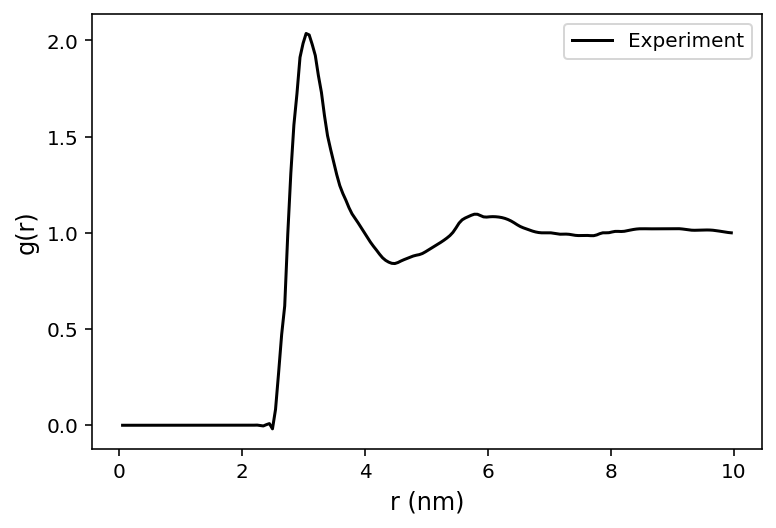

In [10]:
#Read in structure data
data   = pd.read_csv ('rdf_ne42K.csv') 
g_r    = pd.DataFrame (data, columns = ['r','g']) 
expRDF = g_r.values 
r, rdf = zip(*expRDF) 

#Interpolate experimental radial distribution
bins    = 200                                          #number of points in rdf and tabulated potential
exp_r   = np.linspace(r[0], r[-1], bins)            #divide by 10 to convert from Å to nm
sp      = interpolate.splrep(np.array(r), rdf, s=0)
exp_rdf = interpolate.splev(exp_r, sp, der=0)

#Sanity check
plt.plot(exp_r, exp_rdf, color = 'k', label = 'Experiment')
plt.xlabel('r (nm)', fontsize = 12)
plt.ylabel('g(r)'  , fontsize = 12)
plt.legend()
plt.show()

## Set Up Molecular Simulations

This is where we will define the thermodynamic conditions and define a molecular simulation as our model. Classical molecular dynamics (MD) is a powerful computational approach that will allow us to relate interatomic interactions to the radial distribution function. Therefore, we can run classical MD with a given interatomic potential, calculate a simulated radial distribution function from the trajectory file, and then compare this simulated RDF to the experimental one.

An important consideration here is the reference potential. In this example, we have chosen an accurate $\textit{ab initio}$ potential [3] fit to a (12-6) Mie potential reference form. The (n-6) Mie potential is given by,

$$
    v^{Mie}_2(r) = \frac{n}{n-6}\bigg(\frac{n}{6}\bigg)^{\frac{6}{n-6}} \epsilon \bigg[ \bigg(\frac{\sigma}{r}\bigg)^n - \bigg(\frac{\sigma}{r}\bigg)^6 \bigg]
$$

where $n$ is the short-range repulsion exponent, $\sigma$ is the collision diameter (nm), and $\epsilon$ is the dispersion energy (kcal $\cdot$ mol$^{-1}$) [4]. We also need to make sure that the reference potential we choose here matches the nonbonded force in the .xml file required to initiate the mbuild box. See mbuild documentation for documentation on the .xml file format, but the provided .xml can be trivially updated if choosing a different reference potential is desired.

For reference, the units used in this notebook are:

length [=] nm

energy [=] kcal/mol

density [=] atom/nm$^3$

temperature [=] K

time [=] 48.89 fs (~0.5 ps)

In [11]:
#Define particle
name = "Ne"

#Thermodynamic state variables
k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42.2           #temperature,          [K]
kbT = k * av * T     #thermal energy,       [kcal/mol]
ρ   = 0.02477        #experimental density, [particle/Å^3]   

#Simulation settings
δt    = 0.01         #timestep,            [~0.5 ps] -> δt = 0.01 => δt ~ 0.01*0.5 ps = 0.005 ps = 5 fs
Δt    = 15000        #total timesteps,      []

#Select a reference potential (we will use an (n-6) Mie potential)
def mie_pot(r, n, ϵ, σ):
    return (n/(n-6))*(n/6)**(6/(n-6))*ϵ*((σ/r)**n - (σ/r)**6)

# mie:
#     (n-6) Mie potential
# arguments:
#     r = radius value
#     n = repulsion exponent,      []
#     ϵ = dispersion energy,       [kcal/mol]
#     σ = collision diameter,      [nm]
# returns:
#     V = potential energy x = r,  [kcal/mol]

#Mie reference potential parameters 
ref_n = 12           #repulsion exponent,   []
ref_ϵ = 0.112        #dispersion energy,    [kcal/mol]
ref_σ = 2.76        #collision diameter,   [nm]

m = 5
N_particles = 4 * m**3
spacing = 4
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
print('length (Å)  =', L)
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
print('n_particles =', N_particles)

snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles]
snapshot.particles.typeid = [0] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.types = [name]
with gsd.hoomd.open(name='lattice.gsd', mode='wb') as f:
    f.append(snapshot)

length (Å)  = 32
n_particles = 500


## SOPR Settings

There are two tunable parameters that we can define in this section. One is the scaling constant, $\lambda$, used for numerical stability. The other is the average sum-of-square-residual convergence limit (t), defined as,

$$
   \langle [\Delta g^{(n)}(r_i)]^2 \rangle < t
$$

which just checks that the average sum-of-square-residual at all test points is smaller than the value $t$. Note that $\lambda$ and $t$ may be varied but do not largely impact the final result, so it is reasonable to just use the default values:

$\lambda = 0.4$

$t = 1.25 \times 10^{-4}$

In [12]:
#Structure-optimized potential refinement settings
sopr_r_init   = np.ones(len(exp_rdf))  #reference simulated r-values
sopr_rdf_init = np.ones(len(exp_rdf))  #reference simulated rdf 
γ             = 0.2                    #scaling constant to improve numerical stability
  
it_number  = list()                    #used to keep track of iteration
sum_cont   = np.zeros(len(exp_r))      #continuous sum of the difference in the rdfs from SOPR equation
rdf_diff   = np.ones(len(exp_rdf))     #temporary rdf difference function to calculate sum-of-square residuals 
track_ssr  = list()                    #track sum-of-square residuals between experimental and simulated rdf
tolerance  = 1.25e-4                   #defined as average ssr = ssr/(number of points in rdf) (default = 0.0001) 
iterations = 20                        #max number of iterations. Added to terminate program if not converged  

## Iterative Predictor-Corrector

In [13]:
for i in range (iterations):
    it_number.append(i)                                                
    print(i)
    #Initialize SOPR with Mie potential simulation 
    if i == 0:  
        cpu = hoomd.device.CPU()
        sim = hoomd.Simulation(device=cpu, seed=1)
        sim.create_state_from_gsd(filename='lattice.gsd')

        integrator = hoomd.md.Integrator(dt = δt)
        integrator.forces[:]
        cell = hoomd.md.nlist.Cell(buffer=0.4)
        mie = hoomd.md.pair.Mie(nlist=cell)
        mie.params[(name, name)] = dict(epsilon=ref_ϵ, sigma=ref_σ, n=ref_n, m=6)
        mie.r_cut[(name, name)] = 9
        mie.r_on[(name, name)]  = 2.0
        integrator.forces.append(mie)
        nvt = hoomd.md.methods.NVT(kT=kbT, filter=hoomd.filter.All(), tau=1.0)
        integrator.methods.append(nvt)

        sim.operations.integrator = integrator

        snapshot = sim.state.get_snapshot()
        snapshot.particles.velocity[0:5]

        sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kbT)
        thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
            filter=hoomd.filter.All())
        sim.run(Δt)

        ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=Δt*2)
        rho = sim.state.N_particles / sim.state.box.volume
        initial_box = sim.state.box
        final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
        final_rho = ρ
        final_box.volume = sim.state.N_particles / final_rho
        box_resize_trigger = hoomd.trigger.Periodic(10)

        box_resize = hoomd.update.BoxResize(box1=initial_box,
                                            box2=final_box,
                                            variant=ramp,
                                            trigger=box_resize_trigger)
        sim.operations.updaters.append(box_resize)
        sim.run(Δt + 1)
        ramp(sim.timestep - 1)
        current_box = sim.state.box
        (current_box.Lx - initial_box.Lx) / (final_box.Lx - initial_box.Lx)
        sim.run(Δt*2)
        sim.state.box == final_box
        sim.operations.updaters.remove(box_resize)
        gsd_writer = hoomd.write.GSD(filename='mie_tester.gsd',
                                  trigger=hoomd.trigger.Periodic(100),
                                  mode='wb')
        sim.operations.writers.append(gsd_writer)
        thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        sim.operations.computes.append(thermodynamic_properties)
        logger = hoomd.logging.Logger()
        logger.add(thermodynamic_properties)
        gsd_writer.log = logger
        sim.run(Δt)
        
        tic = time.perf_counter()
        with gsd.hoomd.open('mie_tester.gsd', 'rb') as f:
            freud_rdf = freud.density.RDF(bins=len(exp_r), r_max=exp_r[-1], r_min=exp_r[0])
            for frame in f:
                freud_rdf.compute(system=frame, reset=False)
        toc = time.perf_counter()
        print(f'Radial Distribution Function Calculated in {toc - tic:.3} seconds')
                
        sopr_r,sopr_rdf = freud_rdf.bin_centers, freud_rdf.rdf
        sopr_r_init   = sopr_r
        sopr_rdf_init = sopr_rdf
        
    #SOPR tabulated potential simulations
    else:
        tic = time.perf_counter()
        device = hoomd.device.auto_select()
        simulation = hoomd.Simulation(device=device, seed=1)
        simulation.create_state_from_gsd('mie_tester.gsd', frame = int(Δt/100 - 1))
        cell = hoomd.md.nlist.Cell(buffer = 0.4)
        table  = hoomd.md.pair.Table(nlist=cell)
        table.params[(name, name)] = dict(r_min= sopr_r[0], V= V, F= F)
        table.r_cut[(name, name)] = sopr_r[-1]
        integrator = hoomd.md.Integrator(dt = δt)
        integrator.forces.append(table)
        nvt = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT  = kbT)
        integrator.methods = [nvt]
        simulation.operations.integrator = integrator
        gsd_writer = hoomd.write.GSD(filename='tab_eq_tester.gsd',
                                 trigger=hoomd.trigger.Periodic(100),
                                 mode='wb')
        simulation.operations.writers.append(gsd_writer)
        simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT = kbT)
        simulation.run(5000)

        device = hoomd.device.auto_select()
        simulation = hoomd.Simulation(device=device, seed=1)
        gsd_writer = hoomd.write.GSD(filename='tab_tester.gsd',
                                 trigger=hoomd.trigger.Periodic(100),
                                 mode='wb')
        simulation.operations.writers.append(gsd_writer)
        simulation.create_state_from_gsd('tab_eq_tester.gsd', frame = 49)
        cell = hoomd.md.nlist.Cell(buffer = 0.4)
        table  = hoomd.md.pair.Table(nlist=cell)
        table.params[(name, name)] = dict(r_min=sopr_r[0], V = V, F = F)
        table.r_cut[(name, name)] = sopr_r[-1]
        integrator = hoomd.md.Integrator(dt = δt)
        integrator.forces.append(table)
        nvt = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT  = kbT)
        integrator.methods = [nvt]
        simulation.operations.integrator = integrator
        simulation.run(Δt)
        toc = time.perf_counter()
        print(f'Tabulated Simulation Done in {toc - tic:.3} seconds')
         
        tic = time.perf_counter()
        with gsd.hoomd.open('tab_tester.gsd', 'rb') as f:
            freud_rdf = freud.density.RDF(bins=len(exp_r), r_max=exp_r[-1], r_min=exp_r[0])
            for frame in f:
                freud_rdf.compute(system=frame, reset=False)
        sopr_r,sopr_rdf = freud_rdf.bin_centers, freud_rdf.rdf
        toc = time.perf_counter()
        print(f'Radial Distribution Function Done in {toc - tic:.3} seconds')       
    
    tic             = time.perf_counter()
    delg            = np.zeros(len(sopr_r))    #temporary rdf difference function added to continuous sum 
    new_potential   = np.zeros(len(sopr_rdf))  #tabulated potential updated with SOPR equation 
    ϕ               = []                  #new variable for tabulated potential to accomodate Gaussian process 
    GP_r            = []                  #r-values where the Gaussian process is applied
    GP              = []                  #Gaussian process regressed tabulated potential array

    #Numerical implementation of SOPR equation
    for j in range (len(sopr_r)):
        if sopr_r[j] <= 0.9*ref_σ:
            ϕ.append(mie_pot(sopr_r[j], ref_n, ref_ϵ, ref_σ))
        else:
            delg[j]          = (exp_rdf[j] - sopr_rdf[j])*kbT*γ                  #refinement equation
            sum_cont[j]      = sum_cont[j] + delg[j]
            new_potential[j] = mie_pot(sopr_r[j], ref_n, ref_ϵ, ref_σ) - sum_cont[j]
            GP_r.append(sopr_r[j])
            GP.append(new_potential[j])
            
    sig = 0.1                                   #weight parameter (default = 0.01)
    ℓ   = 2                                     #length-scale fluctuation parameter
    td  = array(GP_r, dtype='float64')          #input radius data
    yd  = array(GP - GP[-1], dtype='float64')           #input tabulated potential
    nd  = td.shape[0]                           #size of the input data

    Rdd = radius(td, td)               #euclidean distance between input radii
    Kdd = SquareExp(sig, ℓ, Rdd)       #squared exponential kernel applied to input data

    #Solve eigenvalue problem for Gaussian process
    Λ, V = eigh(Kdd)
    Λ[Λ < 1e-14] = 1e-14  # round-off error correction
    α = V @ ((yd.T @ V) / Λ).T  # inv(Kdd) @ Yd

    ti      = linspace(GP_r[0], GP_r[-1], len(GP_r)) #new points for regression (default is to use input points)
    Rid     = radius(ti, td)                        #euclidean distance between input and output radii
    Rii     = radius(ti, ti)                        #euclidean distance between output radii
    Kid     = SquareExp(sig, ℓ, Rid)                #squared exponential kernel applied to input and output data
    Kii     = SquareExp(sig, ℓ, Rii)                #squared exponential kernel applied to output data
    β       = V @ ((Kid @ V) / Λ).T                   # inv(Kdd) @ Kid
    μ_post  = (Kid @ α)                          #calculate posterior mean
    Σ_post  = Kii - Kid @ β                      #calculate posterior covariance
    σ2_post = maximum(0.0, diag(Σ_post))        #posterior variance
    σ_post  = sqrt(σ2_post)                      #posterior standard deviation
    
    #append Gaussian process regressed points to preserved points at lower-r
    for l in range (len(GP)):
        ϕ.append(μ_post[l])
    
    #Use interpolate command to move data into proper format and calculate numerical derivative (force)
    sp  =  interpolate.splrep(sopr_r, ϕ, s=0)
    V   =  interpolate.splev (sopr_r, sp, der=0)
    F   = -interpolate.splev (sopr_r, sp, der=1)

    #Check for convergence
    sum_squares = 0
    for k in range (len(sopr_r)):                     
        rdf_diff[k] = exp_rdf[k] - sopr_rdf[k]
        sum_squares += rdf_diff[k]**2          #sum-of-square residuals between simulated and experimental data
    
    track_ssr.append(sum_squares/len(exp_r))
    if track_ssr[i] <= tolerance:
        break
    toc = time.perf_counter()
    print(f'Refinement in {toc - tic:.3} seconds')

0
Radial Distribution Function Calculated in 0.686 seconds
Refinement in 0.0365 seconds
1
Tabulated Simulation Done in 2.35e+02 seconds
Radial Distribution Function Done in 0.635 seconds
Refinement in 0.0362 seconds
2
Tabulated Simulation Done in 2.56e+02 seconds
Radial Distribution Function Done in 0.806 seconds
Refinement in 0.0466 seconds
3
Tabulated Simulation Done in 2.79e+02 seconds
Radial Distribution Function Done in 0.718 seconds
Refinement in 0.032 seconds
4
Tabulated Simulation Done in 3.1e+02 seconds
Radial Distribution Function Done in 0.92 seconds
Refinement in 0.0404 seconds


## Visualize the Results

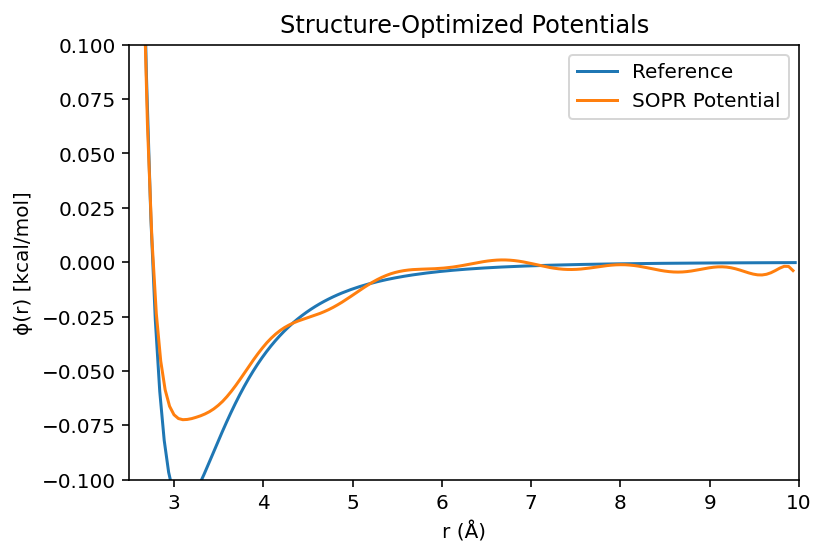

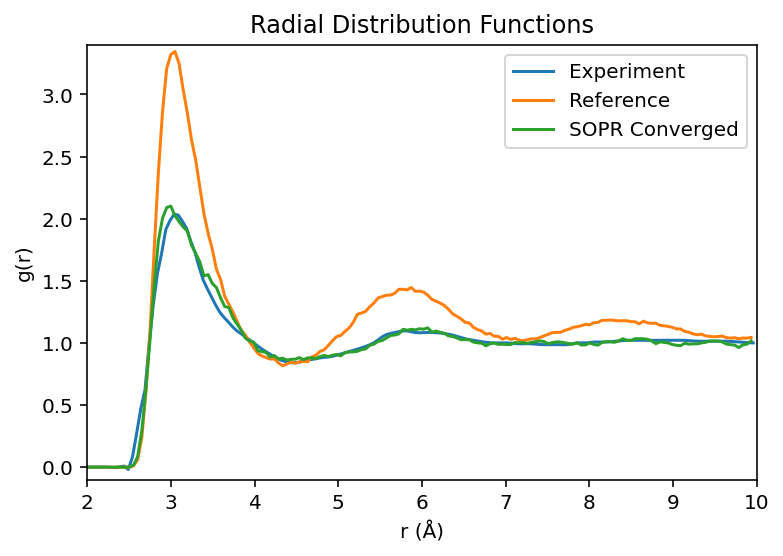

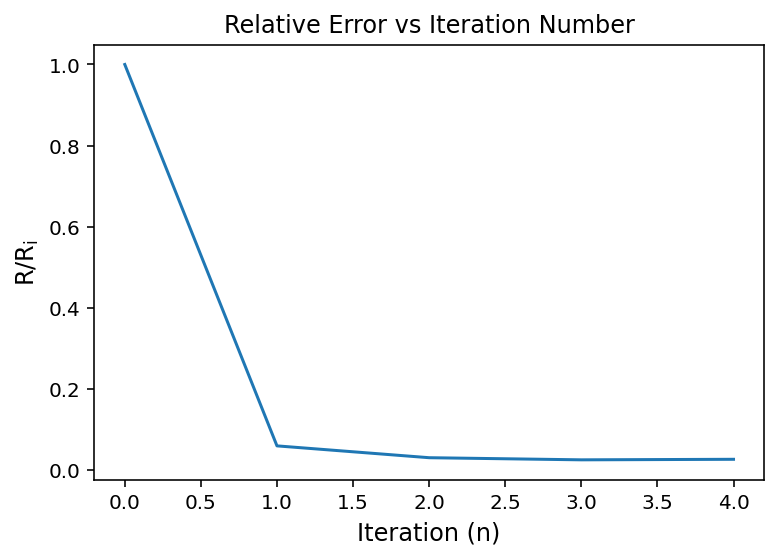

In [14]:
plt.plot(exp_r, mie_pot(exp_r, ref_n, ref_ϵ, ref_σ), label = 'Reference')
plt.plot(sopr_r, V, label = 'SOPR Potential')
plt.xlim(2.5, 10)
plt.ylim(-0.1, 0.1)
plt.xlabel('r (Å)')
plt.ylabel('ϕ(r) [kcal/mol]')
plt.title('Structure-Optimized Potentials')
plt.legend(loc = 'best')
plt.show()

plt.plot(exp_r, exp_rdf, label = 'Experiment')
plt.plot(sopr_r_init, sopr_rdf_init, label = 'Reference')
plt.plot(sopr_r, sopr_rdf, label = 'SOPR Converged')
plt.xlim(2, 10)
plt.ylim(-0.1, 3.4)
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Functions')
plt.legend()
plt.show()

plt.plot(it_number, track_ssr/track_ssr[0])
plt.xlabel('Iteration (n)', fontsize = 12)
plt.ylabel('R/R$_i$', fontsize = 12)
plt.title('Relative Error vs Iteration Number')
plt.show()

## References

[1] (1) Sivia, D. S. Elementary Scattering Theory: For X-Ray and Neutron Users; Oxford University Press, 2011. https://doi.org/10.1093/acprof:oso/9780199228676.001.0001.

[2] Atomistic force field development from experimental diffraction data with structure-optimized potential refinement, 2022. 

[3] (1) Hellmann, R.; Bich, E.; Vogel, E. Ab Initio Potential Energy Curve for the Neon Atom Pair and Thermophysical Properties of the Dilute Neon Gas. I. Neon–Neon Interatomic Potential and Rovibrational Spectra. Molecular Physics 2008, 106 (1), 133–140. https://doi.org/10.1080/00268970701843147.

[4] (1) Mie, G. Zur Kinetischen Theorie Der Einatomigen Körper. Annalen der Physik 1903, 316 (8), 657–697. https://doi.org/10.1002/andp.19033160802.
